In [44]:
import eikon as ek
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.tsa.stattools import coint


In [125]:
api_key = '4019aab16a6b45cf86e11574d74e2e5b3681ee13'
ek.set_app_key(api_key)

# Try: USISME=ECI (Manufacturing employment index)
df=ek.get_timeseries(["aUSIPMANG/CA", "aUSGPYDPC/CA", "aUSWSLS/A", "USWRKW=ECI"],
start_date='2006-12-15',
end_date='2022-8-31',
interval='monthly')

# IP = Industrial Production
# DPI = Disposable Personal Income
# TS = Trade Sales
# AW = Average Workweek
df.columns = ["IP", "DPI", "TS", "AW"]
df.index = pd.to_datetime(df.index, format="%Y-%m%-d")
df.tail()

,IP,DPI,TS,AW
Date,,,,
2022-04-30,102.9031,45229,692466000000,34.6
2022-05-31,102.4763,45164,697250000000,34.6
2022-06-30,101.7132,44960,708222000000,34.5
2022-07-31,102.1307,45174,697323000000,34.5
2022-08-31,102.3092,45201,697252000000,34.5


In [92]:
df.to_csv("data/coincident_indicators.csv")

In [107]:
bar = "--------------------"

def adf_test_on_(dataframe):
    output = pd.DataFrame(index=["p value"])
    for column in dataframe.columns:
        try: 
            pvalue = adf(dataframe[column])[1]
            output.loc["p value", column] = "%1.2f"%pvalue
            #print(column,"\np-value:", "%1.2f"%pvalue, "\n"+bar)
        except ValueError:
            print("There has been some problem with", column)
            continue 
    return output     

def log_df_(dataframe):
    for column in dataframe.columns:
        dataframe[column]=np.log(dataframe[column])
    return dataframe.dropna()

def coint_table(dataframe):
    output = pd.DataFrame(index=dataframe.columns, columns=dataframe.columns)
    for idx in output.index:
        for col in output.columns:
            if idx != col:
                x = dataframe[idx]
                y = dataframe[col]
                output.loc[idx,col] = coint(x,y)[1]
    return output

def standardise(dataframe):
    for col in dataframe.columns:
        dataframe[col] = (dataframe[col]-dataframe[col].mean()) / dataframe[col].std()
    return dataframe


In [100]:
output = adf_test_on_(df)  
print(output.style.to_latex())

\begin{tabular}{lllll}
 & IP & DPI & TS & AW \\
p value & 0.16 & 0.69 & 0.98 & 0.13 \\
\end{tabular}



In [103]:
output = coint_table(df)
print(output.replace(np.nan,'-').style.to_latex())

\begin{tabular}{lllll}
 & IP & DPI & TS & AW \\
IP & - & 0.321725 & 0.174665 & 0.175054 \\
DPI & 0.814755 & - & 0.091015 & 0.538742 \\
TS & 0.971659 & 0.139333 & - & 0.731533 \\
AW & 0.210531 & 0.149117 & 0.026043 & - \\
\end{tabular}



In [76]:
log_df = log_df_(df)
adf_test_on_(log_df)

Industrial Production 
p-value: 0.06 
--------------------
Disposable Personal Income 
p-value: 0.39 
--------------------
Trade Sales 
p-value: 0.98 
--------------------
Average Workweek 
p-value: 0.47 
--------------------


<AxesSubplot: xlabel='Date'>

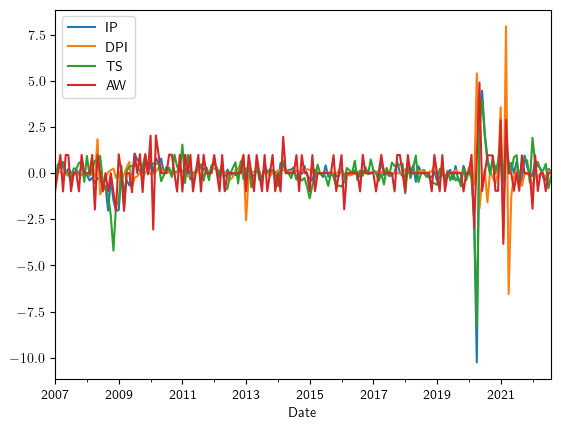

In [109]:
log_df = log_df_(df)
Δlog_df = log_df.diff().dropna()
standard_Δlog_df = standardise(Δlog_df)
standard_Δlog_df.plot()

In [86]:
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [116]:
from numpy import dot, sum, tile, linalg
from numpy.linalg import inv, det
from numpy import log, pi, exp
from numpy import random


def kf_predict(X, P, A, Q, B, U):
    X = dot(A, X) + dot(B, U)
    P = dot(A, dot(P, A.T)) + Q
    return(X,P)


def kf_update(X, P, Y, H, R): 
    IM = dot(H, X)
    IS = R + dot(H, dot(P, H.T)) 
    K = dot(P, dot(H.T, inv(IS))) 
    X = X + dot(K, (Y-IM))
    P = P - dot(K, dot(IS, K.T)) 
    LH = gauss_pdf(Y, IM, IS) 
    return (X,P,K,IM,IS,LH)
    
def gauss_pdf(X, M, S): 
    if M.shape[1] == 1:
        DX = X - tile(M, X.shape[1])
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(det(S)) 
        P = exp(-E)
    elif X.shape[1] == 1:
        DX = tile(X, M.shape[1])- M
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(det(S)) 
        P = exp(-E)
    else:
        DX = X-M
        E = 0.5 * dot(DX.T, dot(inv(S), DX))
        E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(det(S)) 
        P = exp(-E)
        return (P[0],E[0])

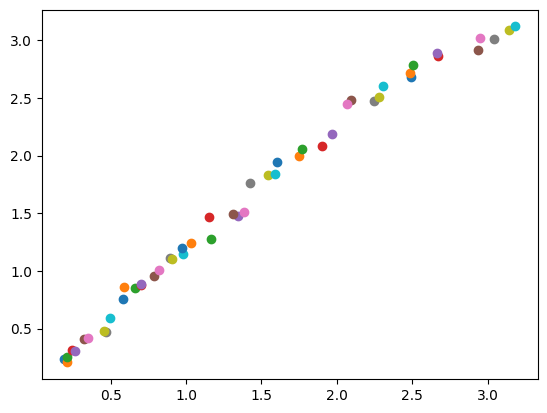

In [139]:

from numpy import *
from numpy.linalg import inv
import matplotlib.pyplot as plt

#time step of mobile movement
dt = 0.1
# Initialization of state matrices
X = array([[0.0], [0.0], [0.1], [0.1]])
P = diag((0.01, 0.01, 0.01, 0.01))
A = array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0,\
 1]])
Q = eye(X.shape[0])
B = eye(X.shape[0])
U = zeros((X.shape[0],1))
# Measurement matrices
Y = array([[X[0,0] + abs(random.randn(1)[0])], [X[1,0] +abs(random.randn(1)[0])]])
H = array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = eye(Y.shape[0])
# Number of iterations in Kalman Filter
N_iter = 50
# Applying the Kalman Filter
for i in arange(0, N_iter):
       (X, P) = kf_predict(X, P, A, Q, B, U)
       (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
       Y = array([[X[0,0] + abs(0.1 * random.randn(1)[0])],[X[1, 0] +\
              abs(0.1 * random.randn(1)[0])]])
       y0 = Y.transpose()[0][0]
       y1 = Y.transpose()[0][1]
       plt.scatter(y0,y1)

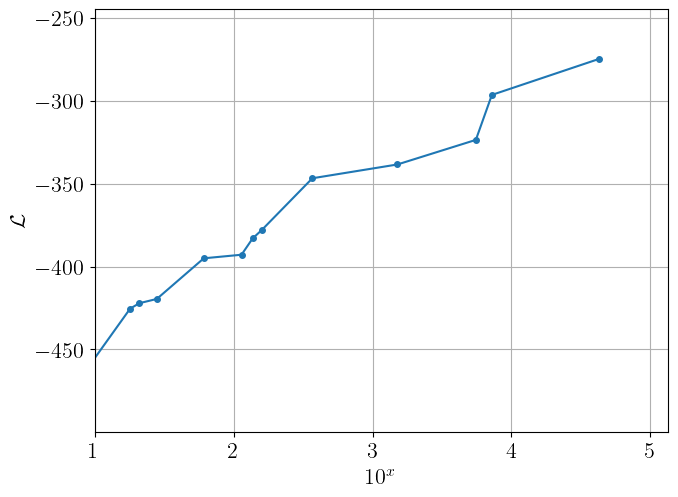

In [150]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter
fig=plt.figure()
ax = fig.gca()
plt.tight_layout()

path = '/Users/ruben/Library/Mobile Documents/com~apple~CloudDocs/phd/uni/courses/2nd year/advanced-econometris-2/replication/fig/'

df = pd.read_csv("results/Ls.csv", index_col="n_iter")
df.index.name=None
df.index = np.log10(df.index)
df.L.plot(ax=ax, marker='o', markersize=4)
ax.set_xlim([1,df.index[-1]+0.5])
ax.set_ylim([-500,df.L.max()+30])
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,3))
ax.set_xlabel("$10^x$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_yticks([-450,-400,-350,-300,-250])
ax.set_xticks([1,2,3,4,5])
ax.set_ylabel(r"$\mathcal{L}$", fontsize=16)
ax.grid()
plt.savefig(path+'L.eps', format='eps', dpi=100, bbox_inches = "tight")

In [68]:
df = pd.read_csv("results/Ls.csv", index_col="n_iter")
df

,Unnamed: 0,L
n_iter,,
4,0,-10.039519
9,1,2.484321
32,2,141.706695
1393,3,211.101537
10284,4,219.428363
27580,5,274.503061
62823,6,290.581569


In [124]:
path = '/Users/ruben/Library/Mobile Documents/com~apple~CloudDocs/phd/uni/courses/2nd year/advanced-econometris-2/replication/tab'
ts_vars = pd.read_csv("results/ts_vars.csv", index_col=0)
ts_vars.columns = ['IP', 'DPI', 'TS', 'AW']
print(ts_vars.style.to_latex())

\begin{tabular}{lrrrr}
 & IP & DPI & TS & AW \\
gammai & 0.592400 & -0.160700 & 0.585400 & 0.320700 \\
d1i & -0.136700 & -0.277700 & 0.298100 & -0.857200 \\
d2i & -0.010300 & -0.796800 & -0.288700 & -0.060500 \\
sigmai & 0.399400 & 0.611400 & 0.013000 & 0.831200 \\
\end{tabular}



In [219]:
C_params = pd.read_csv("results/C_params.csv")
print(C_params.style.to_latex())

\begin{tabular}{lrr}
 & phi1 & phi2 \\
0 & -0.138200 & 0.741300 \\
\end{tabular}



In [1]:
C = pd.read_csv("results/C.csv", index_col=0)
C.index=pd.to_datetime(C.index)
C.plot()

NameError: name 'pd' is not defined

In [13]:
import pandas as pd
import numpy as np
def ts_vars(columns=None) -> pd.DataFrame:
    if columns is not None:
        api_key = '4019aab16a6b45cf86e11574d74e2e5b3681ee13'
        ek.set_app_key(api_key)
        Z = ek.get_timeseries(columns,
        start_date='2014-12-15',
        end_date='2022-8-31',
        interval='monthly')
        Z.columns = ["Industrial Production", "Disposable Personal Income", "Trade Sales", "Average Workweek"]
        Z.index = pd.to_datetime(Z.index, format="%Y-%m%-d")
    else:
        Z = pd.read_csv("data/s&w1989.csv", index_col=0)
        Z.index.name = None
    Y = standardise(Δ(log_df(Z)))
    return Y

def kalman_filter(Y, kf_params) -> tuple:
    # Parameters
    phi     = kf_params['phi']
    D       = kf_params['D']
    Sigma   = kf_params['Sigma']
    beta    = kf_params['beta']
    gamma   = kf_params['gamma']
    delta   = kf_params['delta']
    # Initial values:
    C_vals = []

    # Forecast errors:
    nu = []
    F  = []
    for t in range(len(Y.index)):
        y = Y.iloc[t].to_numpy().reshape(len(Y.columns),1) # I need this because neither .T nor .transpose() is working
        if t==0: kf = KF(Y=y,phi=phi, D=D, Sigma=Sigma, beta=beta, gamma=gamma,delta=delta)
        else: kf = KF(Y=y,phi=phi, D=D, Sigma=Sigma, beta=beta, gamma=gamma,delta=delta, alpha=alpha, P=P)
        kf.predict()
        kf.update()
        # Save the index, C_{t-1}
        C_vals.append(kf.C)
        alpha = kf.alpha
        P     = kf.P
        # Save nu and F:
        nu.append(kf.nu)
        F.append(kf.F)
    return C_vals, nu, F

def update_parameters(  beta: float,
                        delta: float,
                        phi: list,
                        D: dict,
                        Sigma: np.array,
                        gamma: np.array) -> dict:
    d1 = D[1]
    d2 = D[2]
    parameters = {}
    parameters["beta"]  = [beta]
    parameters["delta"] = [delta]
    for i in range(len(d1)):
        i=int(i)
        parameters["d1%i"%(i+1)] = [d1[i,i]]
        parameters["d2%i"%(i+1)] = [d2[i,i]]
        parameters["sigma%i"%(i+1)] = [np.sqrt(Sigma[i+1,i+1])]
        parameters["gamma%i"%(i+1)] = [gamma[i]]
    for j in range(len(phi)):
        j=int(j)
        parameters["phi%i"%(j+1)] = [phi[j]]    
    
    for x in parameters.keys():
        parameters[x] = [round(parameters[x][0], 4)]
    
    return parameters

def kf_parameters(parameters):
    kf_params = {}

    beta = parameters['beta'][0]
    phi = [parameters['phi1'][0],parameters['phi2'][0]]
    D = {
        1: np.diag([parameters['d11'][0],parameters['d12'][0],parameters['d13'][0],parameters['d14'][0]]),
        2: np.diag([parameters['d21'][0],parameters['d22'][0],parameters['d23'][0],parameters['d24'][0]])
    }
    Sigma = np.diag([1,parameters['sigma1'][0]**2,parameters['sigma2'][0]**2,parameters['sigma3'][0]**2,parameters['sigma4'][0]**2])
    gamma = np.array([parameters['gamma1'][0],parameters['gamma2'][0],parameters['gamma3'][0],parameters['gamma4'][0]]).T
    
    kf_params["beta"] = beta
    kf_params["delta"] = delta
    kf_params['phi'] = phi
    kf_params['D'] = D
    kf_params['Sigma'] = Sigma
    kf_params['gamma'] = gamma
    return kf_params 

def log_df(df):
    for col in df.columns:
        df[col] = np.log(df[col])
    df = df.replace(-np.inf,np.nan).dropna()
    return df

def Δ(df):
    df =df.diff()
    df = df.dropna()
    return df

def standardise(dataframe):
    for col in dataframe.columns:
        dataframe[col] = (dataframe[col]-dataframe[col].mean()) / dataframe[col].std()
    return dataframe


In [14]:
phi1 = 0.545
phi2 =  0.032
gamma1 = 0.717
gamma2 = 0.521
gamma3 = 0.470
gamma4 = 0.602
sigma1 = 0.48*1e-2
sigma2 = 0.769*1e-2
sigma3 = 0.735*1e-2
sigma4 = 0.540*1e-2
d11 = -0.040
d12 = -0.087
d13 = -0.41
d14 = 0.108
d21 = -0.137
d22 = 0.154
d23 = -0.206
d24 = 0.48
beta = 0
delta = 0

# Parameters:
phi = [phi1,phi2]
D = {
    1: np.diag([d11,d12,d13,d14]),
    2: np.diag([d21,d22,d23,d24])
}
Sigma = np.diag([1,sigma1**2,sigma2**2,sigma3**2,sigma4**2])
gamma = np.array([gamma1,gamma2,gamma3,gamma4]).T

In [20]:

from kf import KF
Y=ts_vars() 
parameters = update_parameters(beta,delta,phi,D,Sigma,gamma)
kf_params       = kf_parameters(parameters)
C_vals, nu, F   = kalman_filter(Y, kf_params)

In [33]:
from numpy.linalg import det, inv
def L(nu, F) -> float:
    T = len(nu)
    L = 0
    for t in range(T):
        nu_t = nu[t]
        F_t = F[t]
        if det(F_t) > 0:
            F_t_inv = inv(F_t)
            print(nu_t.T)
            L += -float(nu_t.T.dot(F_t_inv).dot(nu_t)) - np.log(det(F_t))
        else:
            L = np.nan
            break
    L *= 1/2
    return L
L(nu,F)

[[ 1.67040542 -0.02163968  1.13962072  0.04382608]]
[[ 0.43192908 -0.31193355  0.39556788  1.32409126]]
[[1.34073754 0.9354205  0.91336485 1.21083521]]
[[ 0.07863125 -0.36440123  0.00514532 -0.87715313]]
[[-0.64122403 -0.22472499 -0.43137852  0.21076874]]
[[-2.94132761 -0.31138303 -0.6757282  -0.96273345]]
[[-2.85450357 -2.04108856 -2.46329829 -1.44926446]]
[[1.36977122 0.37931255 0.57950244 0.29876968]]
[[-0.27601587 -0.30723673  0.29033597 -0.47148118]]
[[1.00382987 3.30069519 0.62070178 1.09254773]]
[[5.22784085 1.32030244 1.84065474 2.46165019]]
[[-0.11163554 -1.83132529 -0.65892968 -2.16786704]]
[[-1.782145   -1.56997538 -1.17861992 -0.26977895]]
[[-0.95588681  0.17097927 -0.57073137 -0.21614771]]
[[-0.74109848  0.06067774  0.18147305  0.91623232]]
[[-0.07469001  0.9926555  -1.14786041 -0.61709026]]
[[-1.30335851 -0.18070895 -0.47737931 -0.83136172]]
[[ 0.06372471 -0.50383925 -0.1779843   0.43193613]]
[[-0.12845747 -1.03852403 -0.44534995 -0.45181827]]
[[-0.88769975 -0.65919973  0

-6860121.275871081

In [ ]:
[ 1.67040542 -0.02163968  1.13962072  0.04382608]

In [1]:
import matplotlib.pyplot as plt 
plt.plot(C_vals)

NameError: name 'C_vals' is not defined

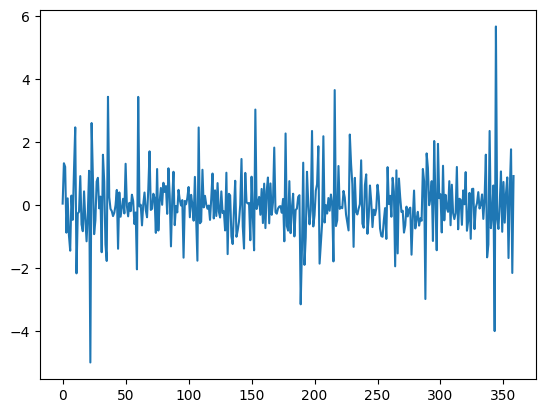

In [26]:
f4 = []
for t in range(len(nu)):
    f4.append(nu[t][-1])
plt.plot(f4)